In [2]:
import matplotlib.pyplot as plt
import pickle
import os
import math
import numpy as np
from od.social import SocialGroup
from od.network.types import ResourceAllocatorType,BaseStationType
from od.misc.interest import InterestConfig
from od.misc.statistic import NetFlowType
from numpy import random
plt.rcParams.update(
    {
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "legend.loc":"upper left",
    "legend.framealpha":0.3,
    "font.size":26,
    "figure.autolayout":True,
    "figure.dpi": 100,
    "axes.titlesize":"medium",
    "legend.fontsize":"x-small",
    'figure.figsize': [6,4],

    }
)
os.getcwd()

'/home/OD/repos/ProjectSumo'

In [3]:
# create picture folder
dirpath = "pics/"
if not os.path.isdir(dirpath):
    os.mkdir(dirpath)

In [4]:
# plt.rcParams.keys()

In [5]:
def GetLineMarkerStyle(line_no):
    line_style = ['--','-.',':']
    marker_style = ['o','v','^','<','>','s','p','*','h','H','x','D']
    line_no = line_no % (len(line_style)*len(marker_style))
    return marker_style[int(line_no%len(marker_style))] + line_style[int(line_no/(len(marker_style)))]
#     return marker_style[int(line_no/len(line_style))] + line_style[int(line_no%(len(line_style)))]

In [6]:
bs_names = {
    BaseStationType.UMA: "4G-eNB",
    BaseStationType.UMI: "5G-gNB",
}

In [7]:
def ExtractAbbreviations(abbrev):
    if(abbrev.lower() == "avg"):
        return "Average"
    elif(abbrev.lower() == "max"):
        return "Maximum"
    elif(abbrev.lower() == "min"):
        return "Minimum"

In [8]:
def BaseStationScenario(with_rsu):
    if(with_rsu):
        return "4G+5G"
    else:
        return  "4G"

In [9]:
def AdjustResAllocTypeName(alloc_type):
    if(alloc_type == ResourceAllocatorType.OMA):
        return "OMA"
    elif(alloc_type == ResourceAllocatorType.NOMA_OPT):
        return "NOMA"

In [10]:
def ScenarioPrefix(req_rsu, req_sa_qr):
    if not req_rsu:
        return "MC"
    elif not req_sa_qr:
        return "SA"
    return "SA+QR"

In [42]:
seed_range = {i+ 1 for i in range(20)} - {13,2,20,8}
res_alloc_type_range = [ResourceAllocatorType.NOMA_OPT]
req_rsu_range = [False, True]
traffic_scale_range = {round(0.3 + i*0.1,1) for i in range(13)}
req_sa_qr = True

In [43]:
interest_config = InterestConfig(None, False, 0)
stats = {
        seed:{
        res_alloc_type :{
            req_rsu:{
                traffic_scale: None 
                for traffic_scale in traffic_scale_range
            }
            for req_rsu in req_rsu_range
        }
        for res_alloc_type in res_alloc_type_range
    }
    for seed in seed_range
}
for seed in seed_range:
    for res_alloc_type in res_alloc_type_range:
        for req_rsu in req_rsu_range:
            for traffic_scale in traffic_scale_range:
                interest_config.res_alloc_type = res_alloc_type
                interest_config.req_rsu = req_rsu
                interest_config.traffic_scale = traffic_scale
                try:
                    
                    with open("data/yQoS/{}/{}/report.pickle".format(seed,str(interest_config)), "rb") as file:
                    # with open("data/yQoS/{}/{}/report_adjust_wait_time_nQoS.pickle".format(seed,str(interest_config)), "rb") as file:
                        stats[seed][res_alloc_type][req_rsu][traffic_scale] = pickle.load(file)
                except:
                    print("missing: {} seed({})".format(str(interest_config),seed))

In [44]:
np.argsort([stats[seed][ResourceAllocatorType.NOMA_OPT][True][1.5]['end-to-end']['GENERAL']['avg'] for seed in seed_range]) + 1

array([ 8,  3,  5, 15, 13, 11, 10, 16,  2, 14,  4,  1,  7, 12,  9,  6])

In [45]:
from matplotlib.ticker import MaxNLocator
graphs = {}
class Line:
    def __init__(self,label,x,y):
        self.label = label
        self.x = x
        self.y = y
class Graph:
    def __init__(self,title,xlabel,ylabel):
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.lines = []
    def addLine(self,line:Line):
        self.lines.append(line)
def ShowGraphs(graphs,save):
    for _g,(title,graph) in enumerate(graphs.items()):
        plt.figure(_g, figsize=(9, 5))
        plt.title(title)
        plt.xlabel(graph.xlabel)
        plt.ylabel(graph.ylabel)
        plt.gca().xaxis.set_major_locator(MaxNLocator(5,min_n_ticks=3))
        for _l, line in enumerate(graph.lines):
            plt.plot(
                line.x,
                line.y,
                GetLineMarkerStyle(_l),
                label=line.label
            )
        plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
        if save :
            plt.savefig('{}/{}.pdf'.format(dirpath, title))
    plt.show()

In [46]:
configs = [
    {
        "catalog": "end-to-end",
        "topic": "End-to-End Time",
        "x": "Average Number of Vehicles",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
    {
        "catalog": "wait-time",
        "topic": "Wait Time",
        "x": "Average Number of Vehicles",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
    {
        "catalog": "tx-time",
        "topic": "Transfer Time",
        "x": "Average Number of Vehicles",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
]


# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            for res_alloc_type in res_alloc_type_range:
                title =  "{} {}({},{})".format(
                    ExtractAbbreviations(subject), 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title,config["x"],config["y"])
                graph = graphs[title]
                for nft in NetFlowType if req_rsu else [NetFlowType.CRITICAL, NetFlowType.GENERAL]:
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][nft.name][subject]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v*1000)
                        y.append(sum(value)/len(value))
                    graph.addLine(
                        Line("{}:{}".format(ScenarioPrefix(req_rsu,req_sa_qr), nft.name.lower()),x,y)
                    )

In [47]:
configs = [
    {
        "catalog": "bst-thrput",
        "topic": "Throughput",
        "x": "Average Number of Vehicles",
        "y": "Megabits",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            if(subject.name == "UMI" and req_rsu == False):
                continue
            for res_alloc_type in res_alloc_type_range:
                title = "{} {}({},{})".format(
                    subject.name, 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title,config["x"],config["y"])
                graph = graphs[title]
                if(subject.name=="UMI"):
                    nfts = [NetFlowType.CRITICAL]
                elif(subject.name =="UMA"):
                    if req_rsu:
                        nfts = NetFlowType
                    else:
                        nfts = [NetFlowType.CRITICAL, NetFlowType.GENERAL]
                nfts = list(map(lambda x: x.name,nfts)) + ["total"]
                for nft in nfts:
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][subject.name][nft]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v/(10**6))
                        y.append(sum(value)/len(value))
                    graph.addLine(
                        Line("{}:{}".format(ScenarioPrefix(req_rsu,req_sa_qr),nft.lower()),x,y)
                    )

In [48]:
configs = [
    {
        "catalog": "bst-sg-rate",
        "topic": "QoS Service Traffic Ratio",
        "x": "Average Number of Vehicles",
        "y": "Percentage",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]


# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            if(subject.name == "UMI" and req_rsu == False):
                continue
            for res_alloc_type in res_alloc_type_range:
                title = "{} {}({},{})".format(
                    subject.name, 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title,config["x"],config["y"])
                graph = graphs[title]
                if(subject.name=="UMI"):
                    nfts = [NetFlowType.CRITICAL]
                elif(subject.name =="UMA"):
                    if req_rsu:
                        nfts = NetFlowType
                    else:
                        nfts = [NetFlowType.CRITICAL, NetFlowType.GENERAL]
                nfts = list(map(lambda x: x.name,nfts))
                for nft in nfts:
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][subject.name][nft]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v*100)
                        y.append(sum(value)/len(value))
                    graph.addLine(
                        Line("{}:{}".format(ScenarioPrefix(req_rsu,req_sa_qr),nft.lower()),x,y)
                    )

In [49]:
configs = [
    {
        "catalog": "sys-thrput",
        "topic": "System Throughput",
        "x": "Average Number of Vehicles",
        "y": "Megabits",
    },
]


# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    title = topic
    if(title not in graphs):
        graphs[title] = Graph(title,config["x"],config["y"])
    graph = graphs[title]
    for req_rsu in req_rsu_range:
        for res_alloc_type in res_alloc_type_range:
            y = []
            x = [x * 100 for x in traffic_scale_range]
            for traffic_scale in traffic_scale_range:
                value = []
                for seed in seed_range:
                    v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog]["total"]
                    if v == _pinf or v == _ninf:
                        v = 0
                    value.append(v/10**6)
                y.append(sum(value)/len(value))
            graph.addLine(
                        Line( 
                            "{}:{}/{}".format(
                                ScenarioPrefix(req_rsu,req_sa_qr),
                                AdjustResAllocTypeName(res_alloc_type),
                                BaseStationScenario(req_rsu)
                            ),
                             x,
                             y
                        )
            )

<ipython-input-45-8838a8c7dcb4>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(_g, figsize=(9, 5))


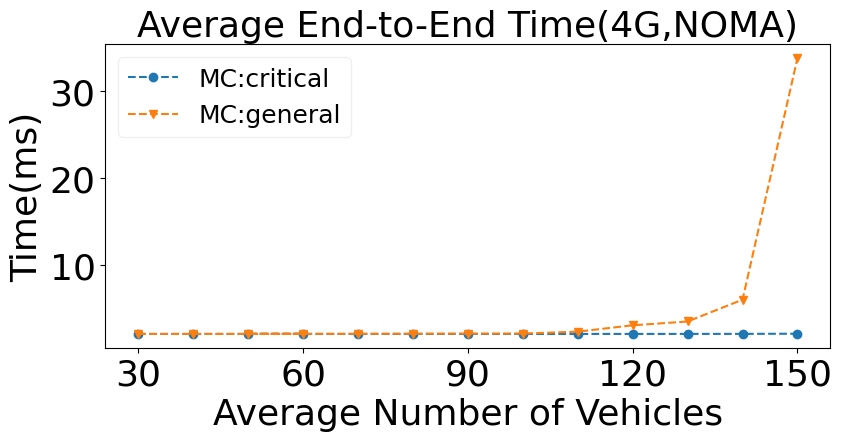

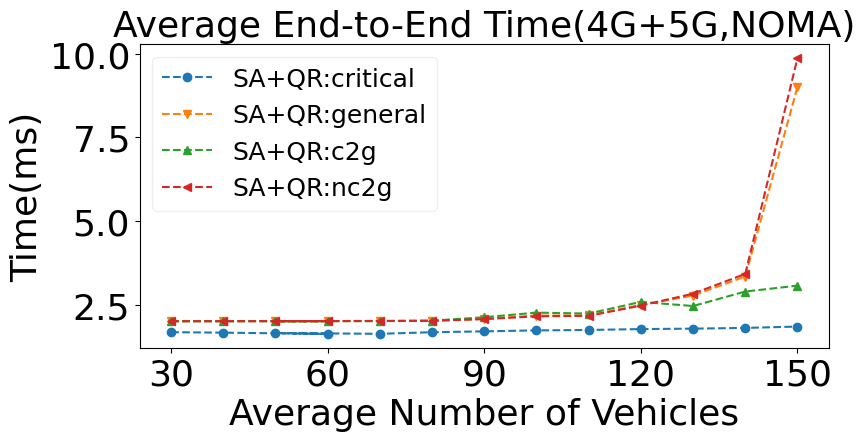

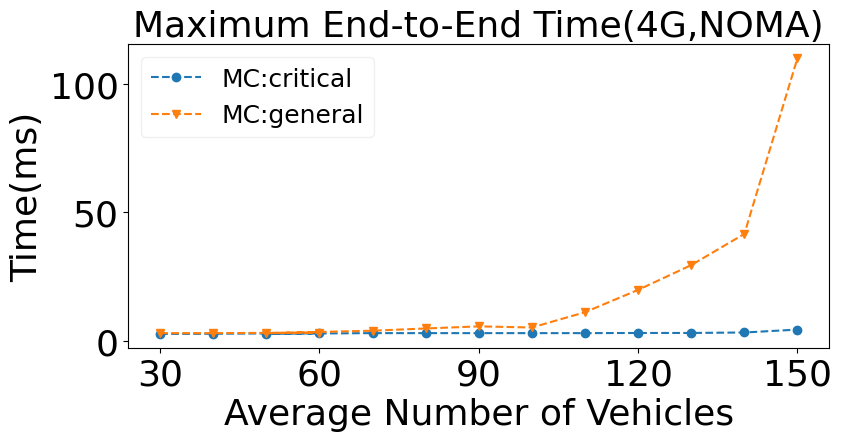

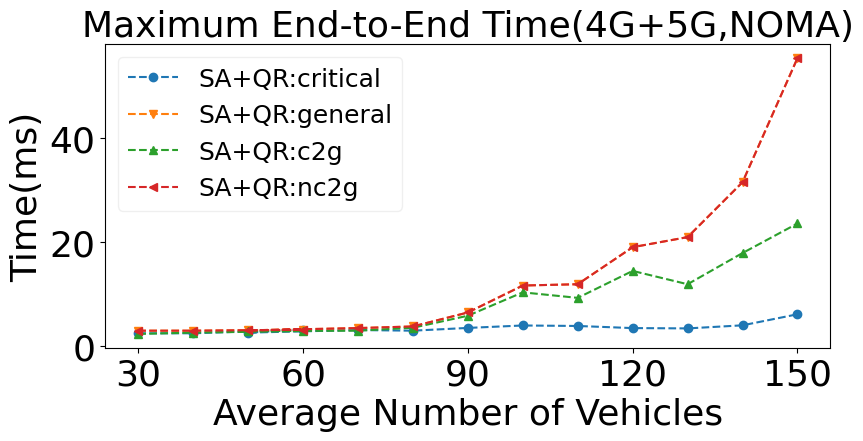

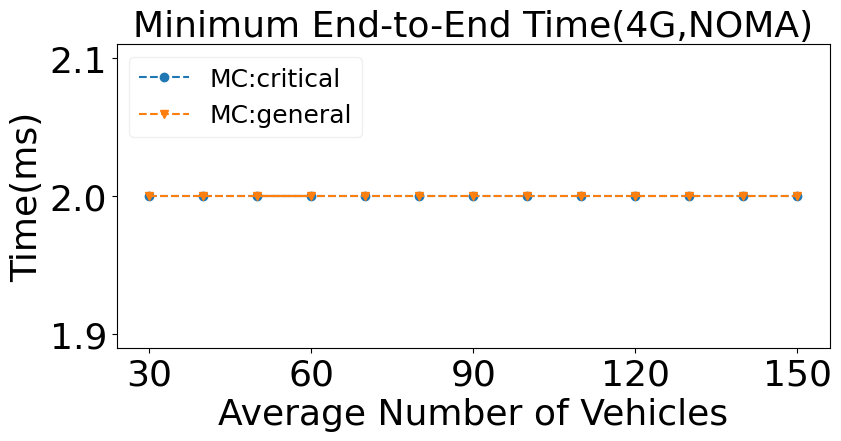

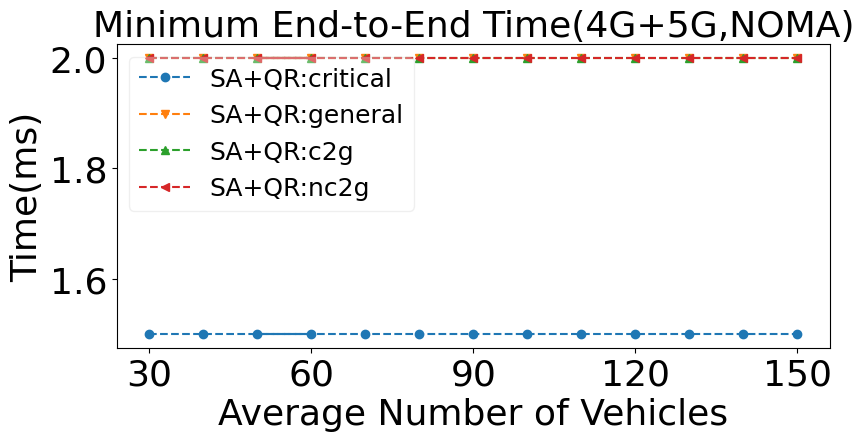

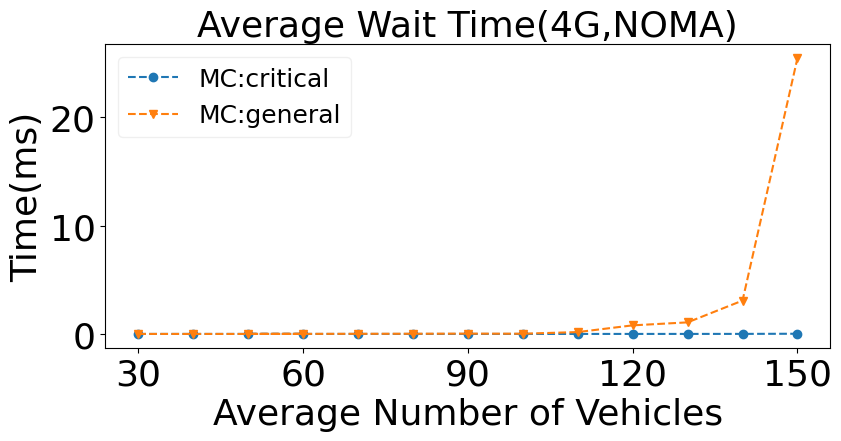

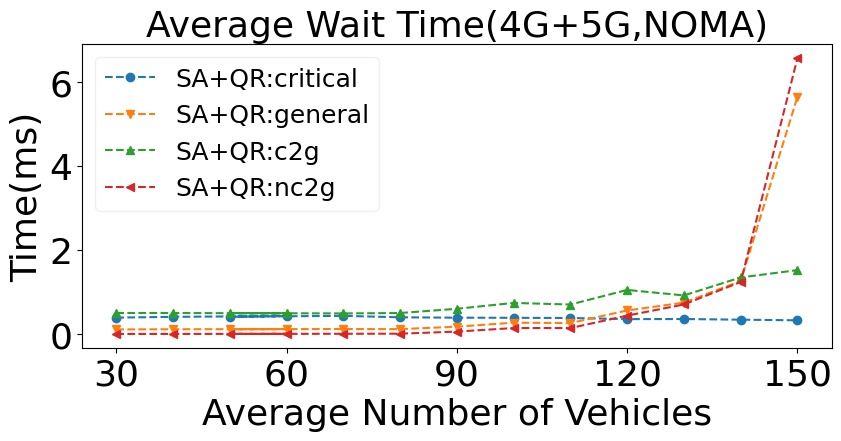

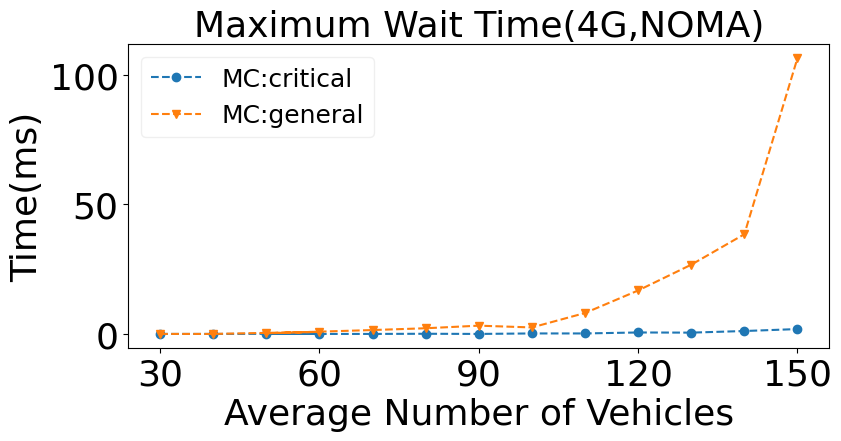

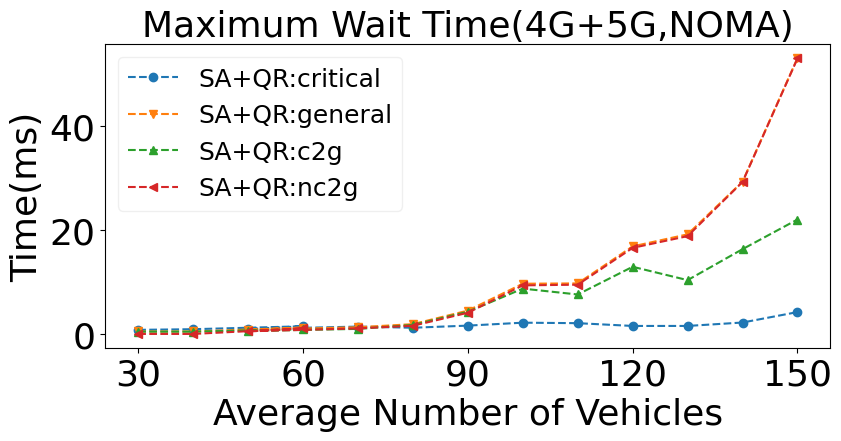

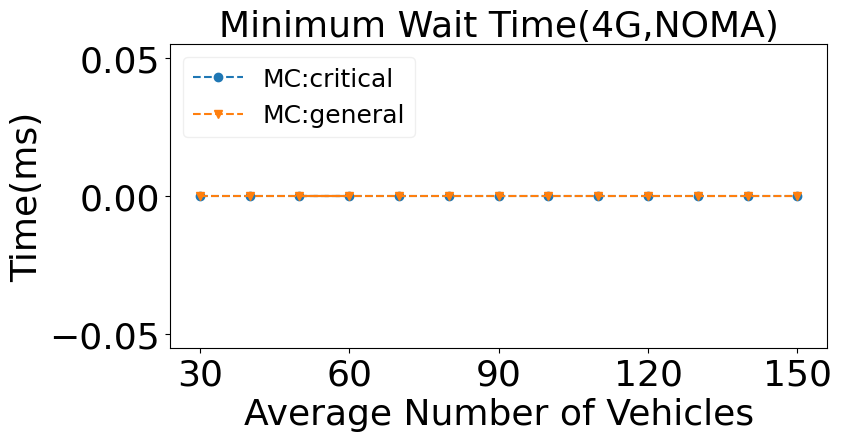

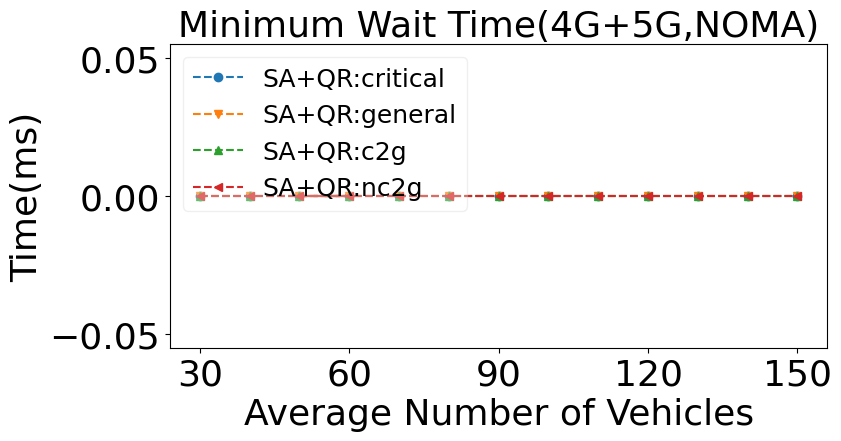

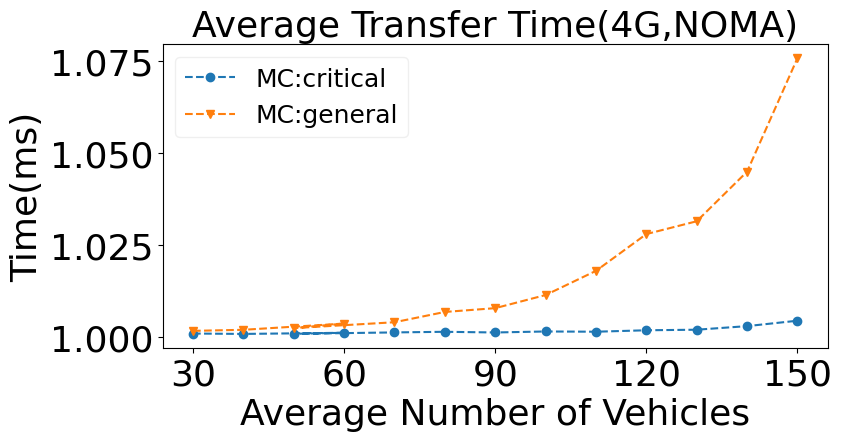

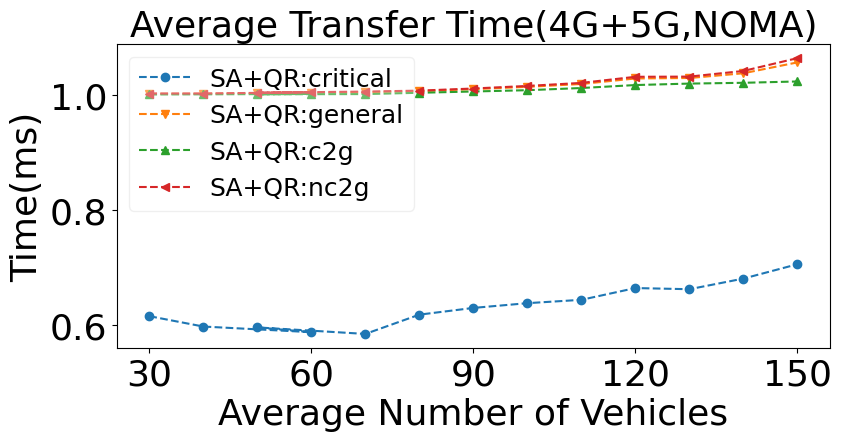

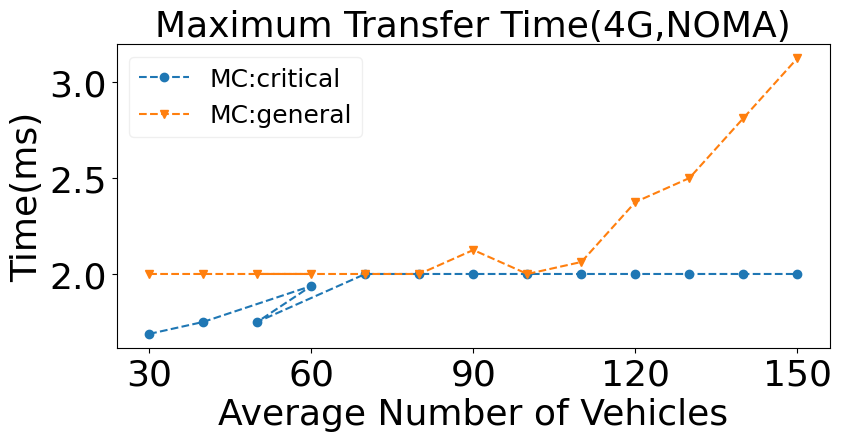

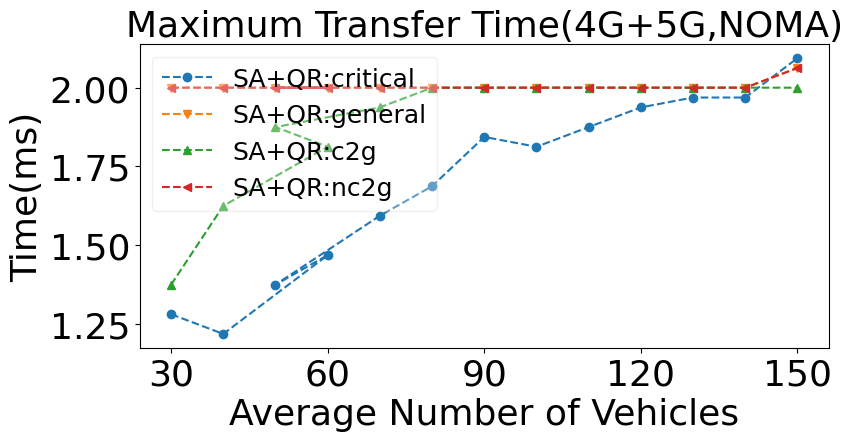

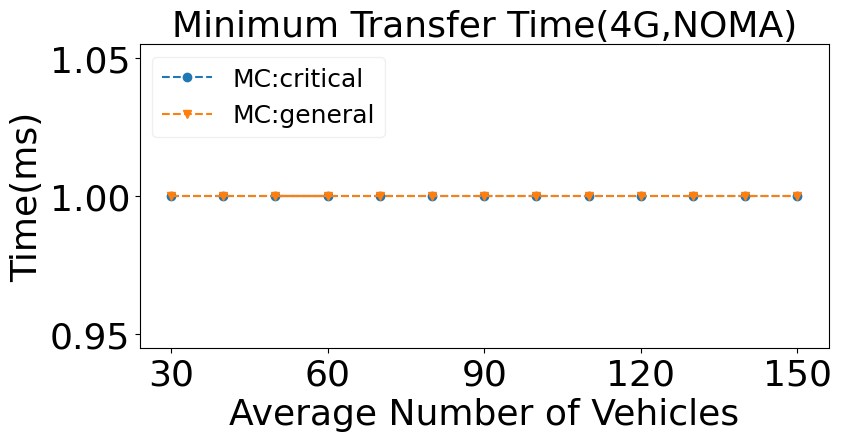

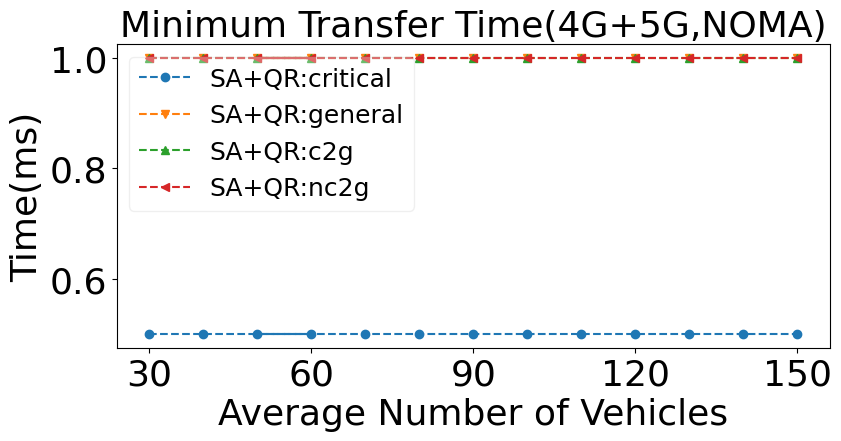

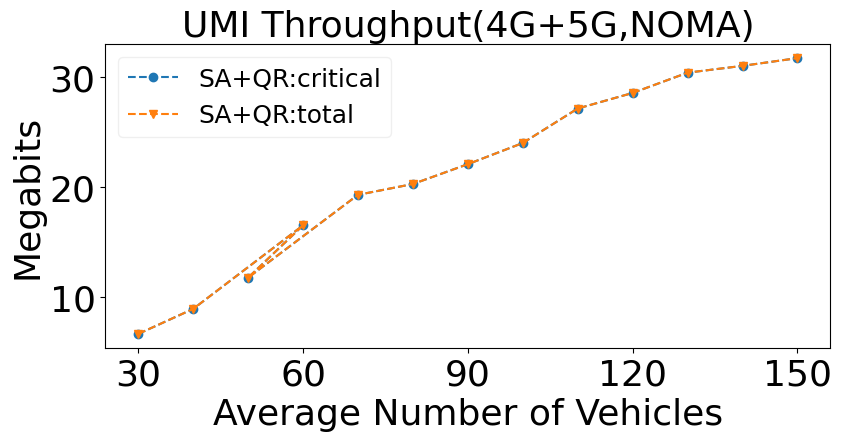

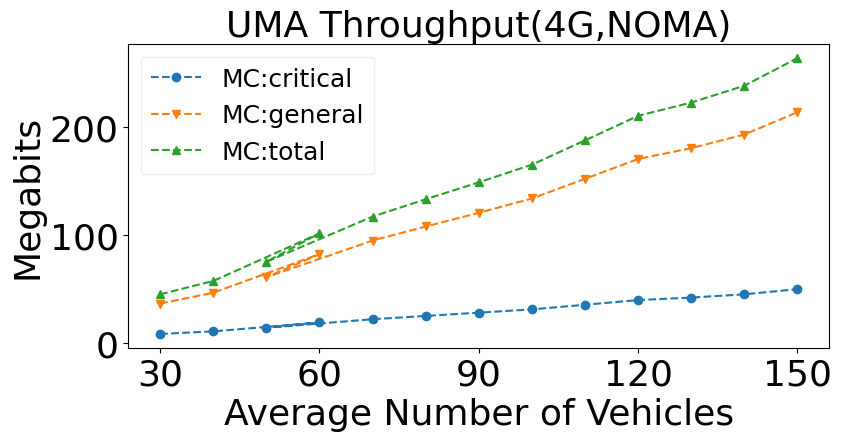

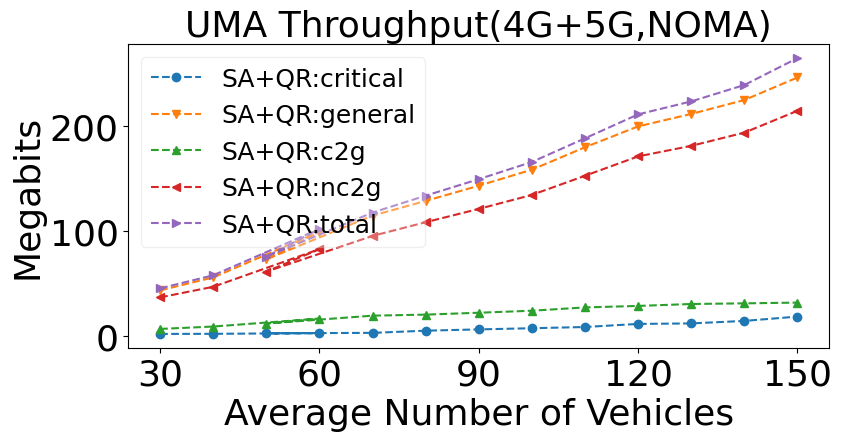

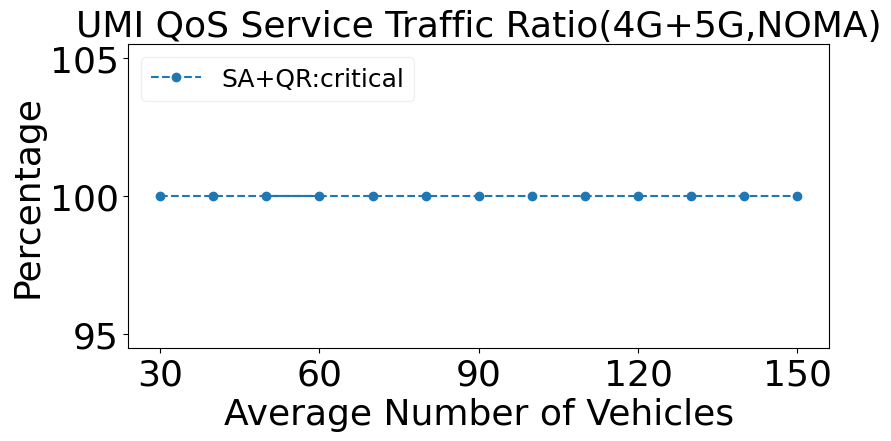

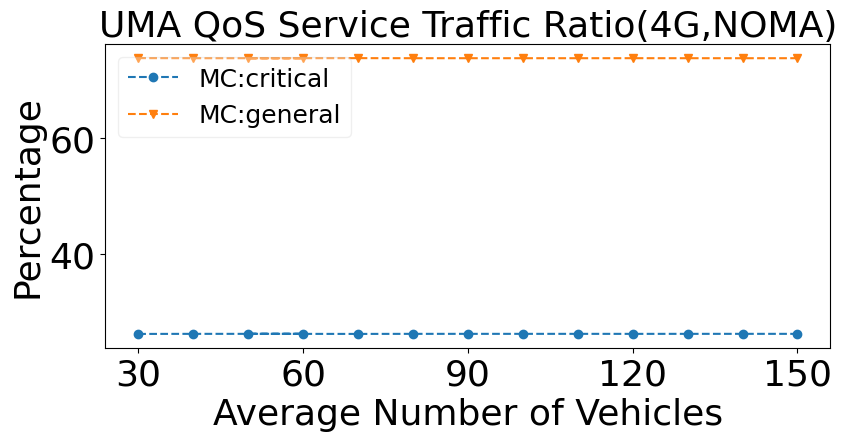

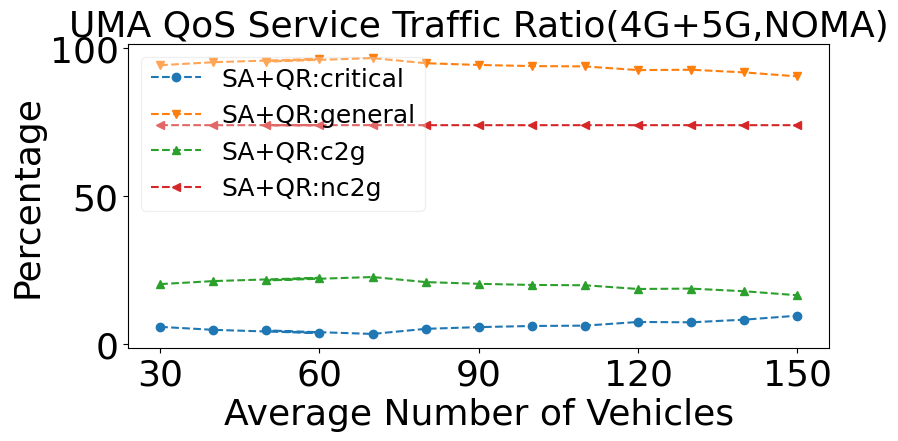

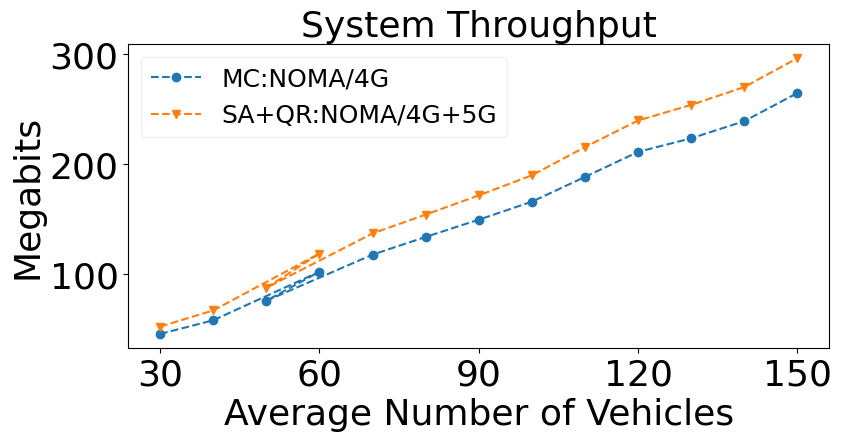

In [50]:
ShowGraphs(graphs,True)

In [20]:
print("Additional Lines")

Additional Lines


In [21]:
res_alloc_type_range = [ResourceAllocatorType.NOMA_OPT]
req_rsu_range = [True]
req_sa_qr = False

In [22]:
interest_config = InterestConfig(None, False, 0)
stats = {
        seed:{
        res_alloc_type :{
            req_rsu:{
                traffic_scale: None 
                for traffic_scale in traffic_scale_range
            }
            for req_rsu in req_rsu_range
        }
        for res_alloc_type in res_alloc_type_range
    }
    for seed in seed_range
}
for seed in seed_range:
    for res_alloc_type in res_alloc_type_range:
        for req_rsu in req_rsu_range:
            for traffic_scale in traffic_scale_range:
                interest_config.res_alloc_type = res_alloc_type
                interest_config.req_rsu = req_rsu
                interest_config.traffic_scale = traffic_scale
                try:
                    with open("data/nQoS/{}/{}/report.pickle".format(seed,str(interest_config)), "rb") as file:
                    # with open("data/nQoS/{}/{}/report_adjust_wait_time_nQoS.pickle".format(seed,str(interest_config)), "rb") as file:
                        stats[seed][res_alloc_type][req_rsu][traffic_scale] = pickle.load(file)
                except:
                    print("missing: {} seed({})".format(str(interest_config),seed))

In [23]:
configs = [
    {
        "catalog": "end-to-end",
        "topic": "End-to-End Time",
        "x": "Average Number of Vehicles",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
    {
        "catalog": "wait-time",
        "topic": "Wait Time",
        "x": "Average Number of Vehicles",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
    {
        "catalog": "tx-time",
        "topic": "Transfer Time",
        "x": "Average Number of Vehicles",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
]


# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            for res_alloc_type in res_alloc_type_range:
                title =  "{} {}({},{})".format(
                    ExtractAbbreviations(subject), 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title,config["x"],config["y"])
                graph = graphs[title]
                for nft in [NetFlowType.CRITICAL, NetFlowType.GENERAL]:
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][nft.name][subject]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v*1000)
                        value.sort()
                        y.append(sum(value)/len(value))
                    graph.addLine(Line("{}:{}".format(ScenarioPrefix(req_rsu,req_sa_qr),nft.name.lower()),x,y))

In [24]:
configs = [
    {
        "catalog": "bst-thrput",
        "topic": "Throughput",
        "x": "Average Number of Vehicles",
        "y": "Megabits",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            if(subject.name == "UMI" and req_rsu == False):
                continue
            for res_alloc_type in res_alloc_type_range:
                title = "{} {}({},{})".format(
                    subject.name, 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title,config["x"],config["y"])
                graph = graphs[title]
                if(subject.name=="UMI"):
                    nfts = [NetFlowType.CRITICAL]
                elif(subject.name =="UMA"):
                    nfts = [NetFlowType.CRITICAL, NetFlowType.GENERAL]
                nfts = list(map(lambda x: x.name,nfts)) + ["total"]
                for nft in nfts:
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][subject.name][nft]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v/(10**6))
                        y.append(sum(value)/len(value))
                    graph.addLine(
                        Line("{}:{}".format(ScenarioPrefix(req_rsu,req_sa_qr),nft.lower()),x,y)
                    )

In [25]:
configs = [
    {
        "catalog": "bst-sg-rate",
        "topic": "QoS Service Traffic Ratio",
        "x": "Average Number of Vehicles",
        "y": "Percentage",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]


# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            if(subject.name == "UMI" and req_rsu == False):
                continue
            for res_alloc_type in res_alloc_type_range:
                title = "{} {}({},{})".format(
                    subject.name, 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title,config["x"],config["y"])
                graph = graphs[title]
                if(subject.name=="UMI"):
                    nfts = [NetFlowType.CRITICAL]
                elif(subject.name =="UMA"):
                    nfts = [NetFlowType.CRITICAL, NetFlowType.GENERAL]
                nfts = list(map(lambda x: x.name,nfts))
                for nft in nfts:
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][subject.name][nft]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v*100)
                        y.append(sum(value)/len(value))
                    graph.addLine(
                        Line("{}:{}".format(ScenarioPrefix(req_rsu,req_sa_qr),nft.lower()),x,y)
                    )

In [26]:
configs = [
    {
        "catalog": "sys-thrput",
        "topic": "System Throughput",
        "x": "Average Number of Vehicles",
        "y": "Megabits",
    },
]


# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    title = topic
    if(title not in graphs):
        graphs[title] = Graph(title,config["x"],config["y"])
    graph = graphs[title]
    for req_rsu in req_rsu_range:
        for res_alloc_type in res_alloc_type_range:
            y = []
            x = [x * 100 for x in traffic_scale_range]
            for traffic_scale in traffic_scale_range:
                value = []
                for seed in seed_range:
                    v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog]["total"]
                    if v == _pinf or v == _ninf:
                        v = 0
                    value.append(v/10**6)
                y.append(sum(value)/len(value))
            graph.addLine(
                        Line( 
                            "{}:{}/{}".format(
                                ScenarioPrefix(req_rsu,req_sa_qr),
                                AdjustResAllocTypeName(res_alloc_type),
                                BaseStationScenario(req_rsu)
                            ),
                             x,
                             y
                        )
            )

<ipython-input-14-8838a8c7dcb4>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(_g, figsize=(9, 5))


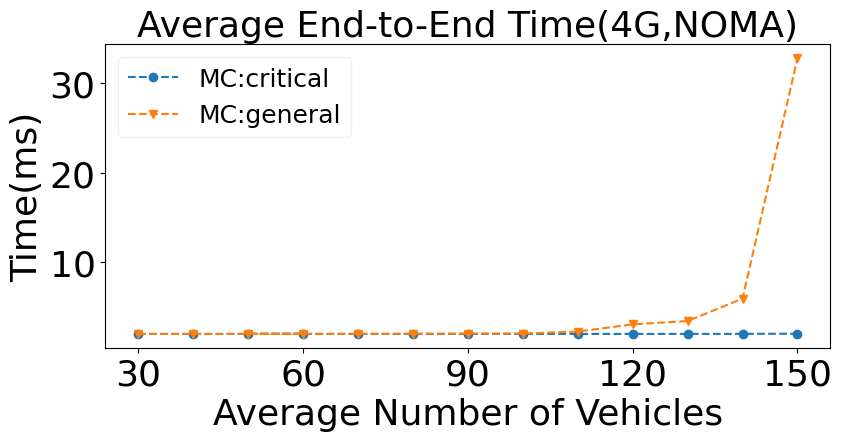

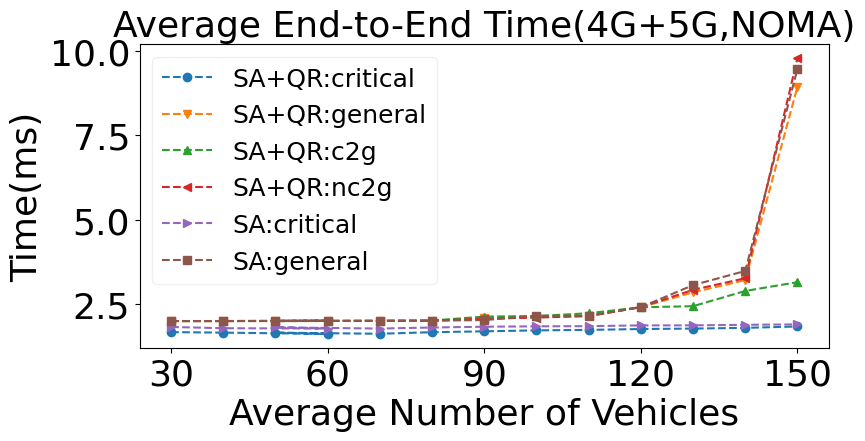

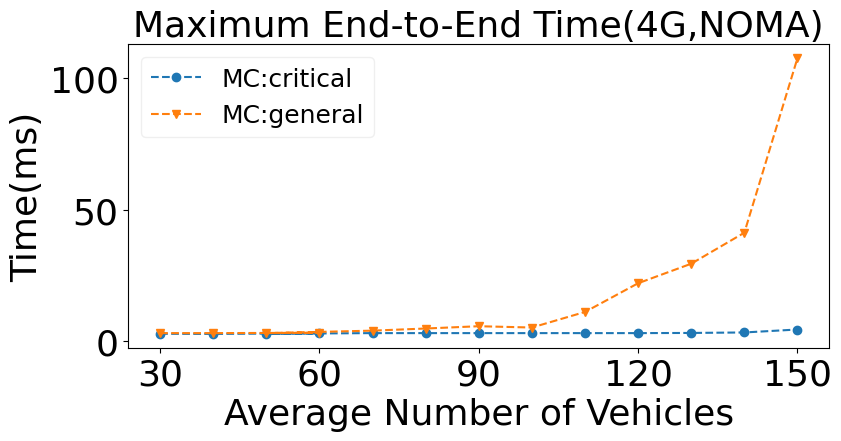

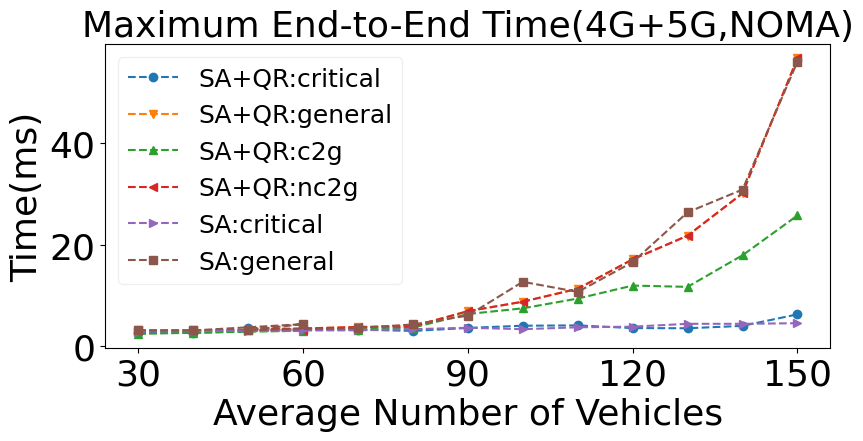

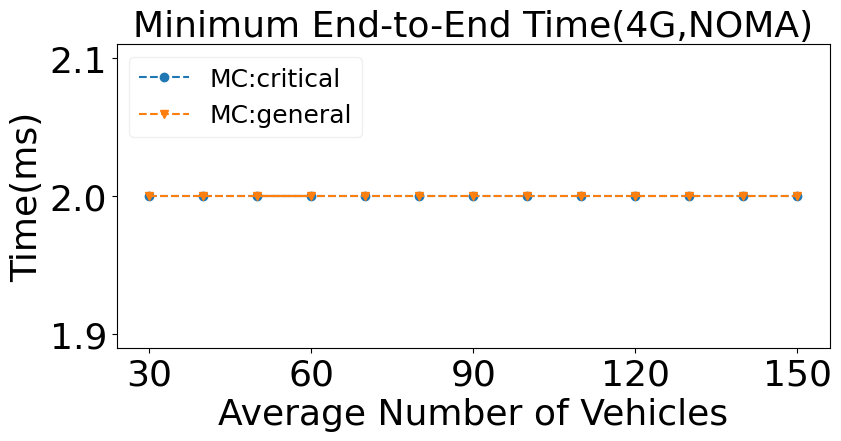

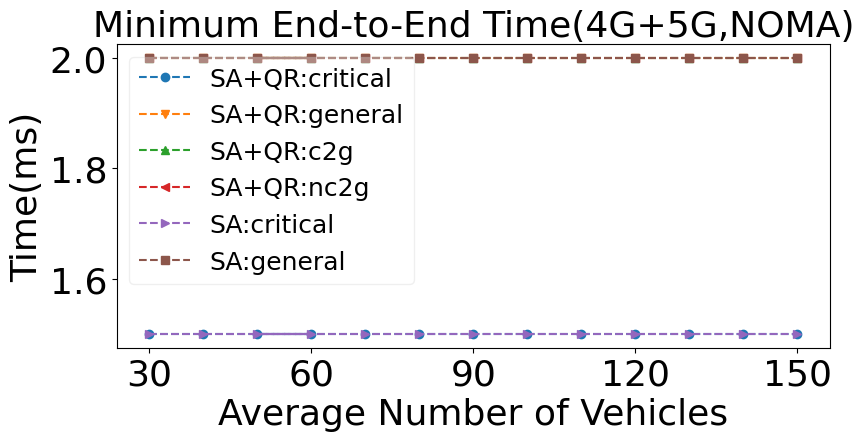

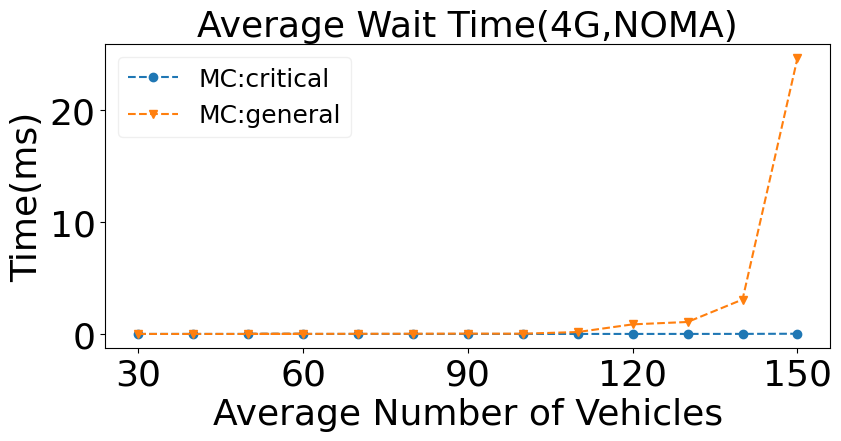

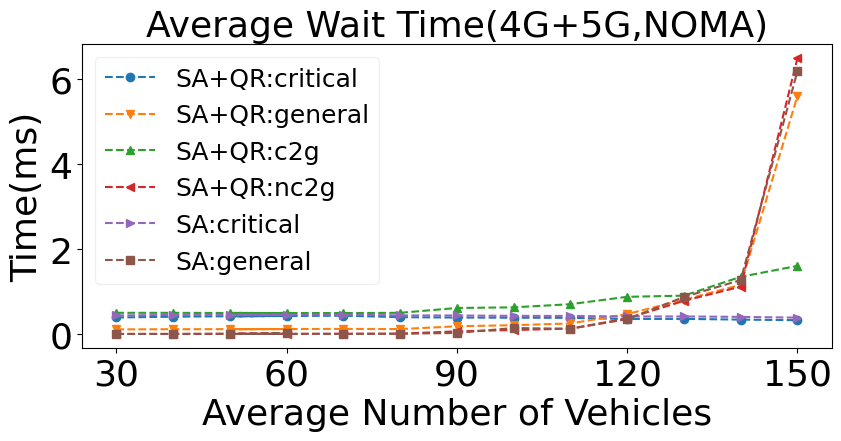

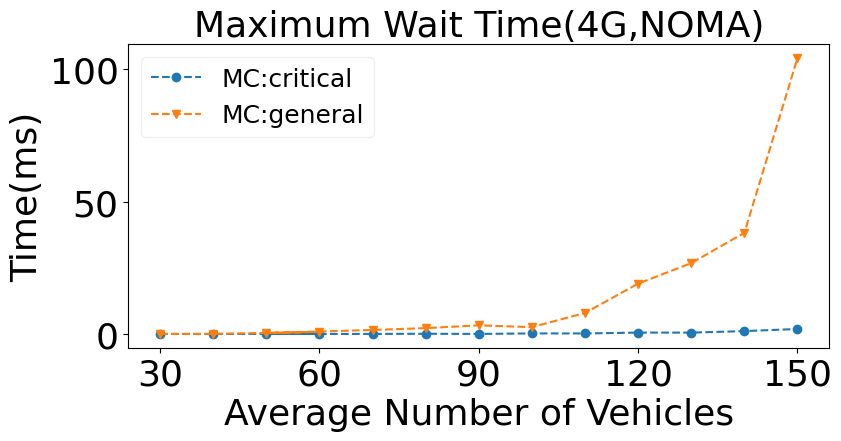

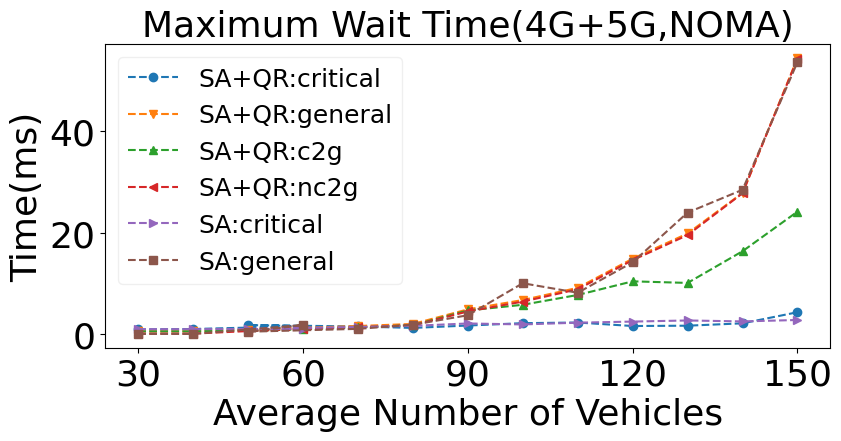

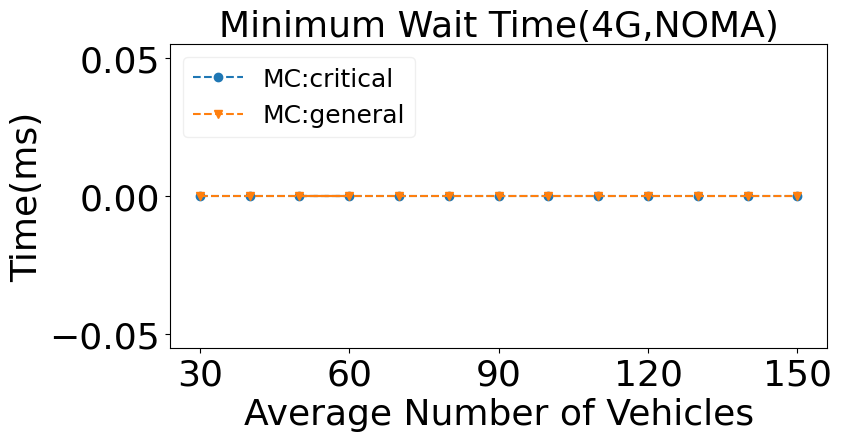

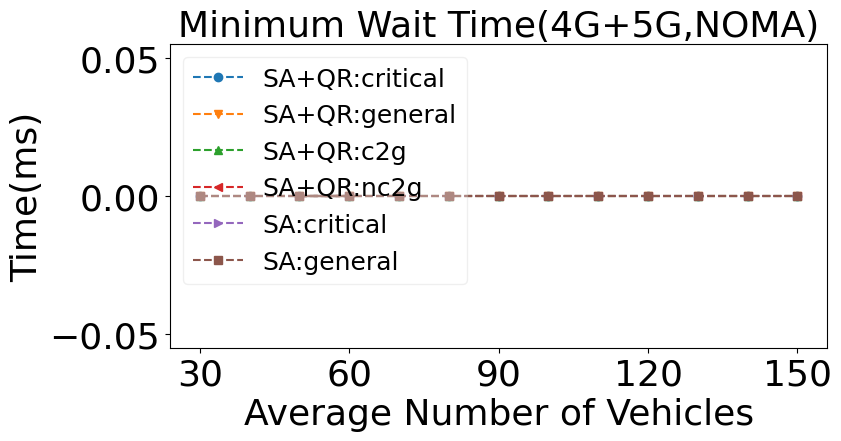

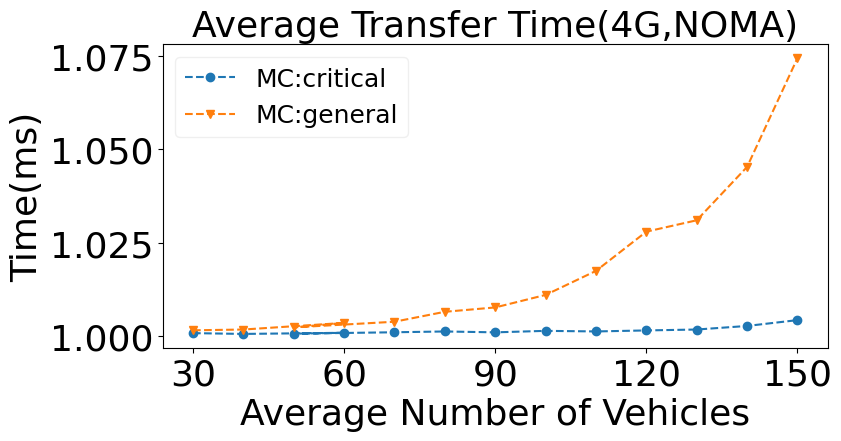

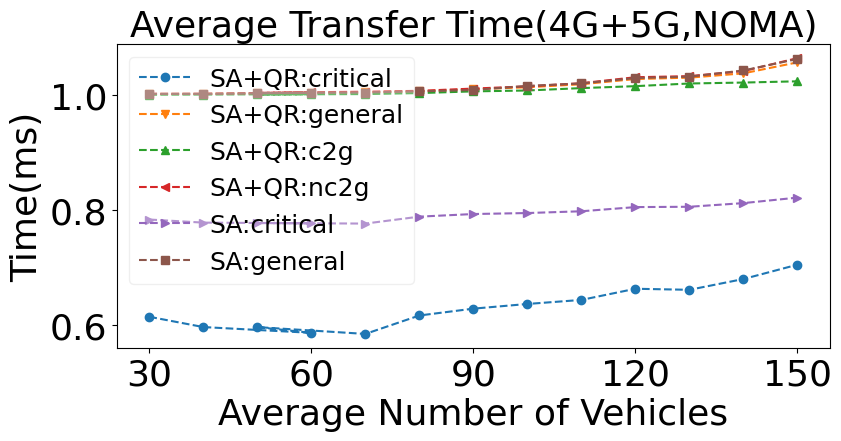

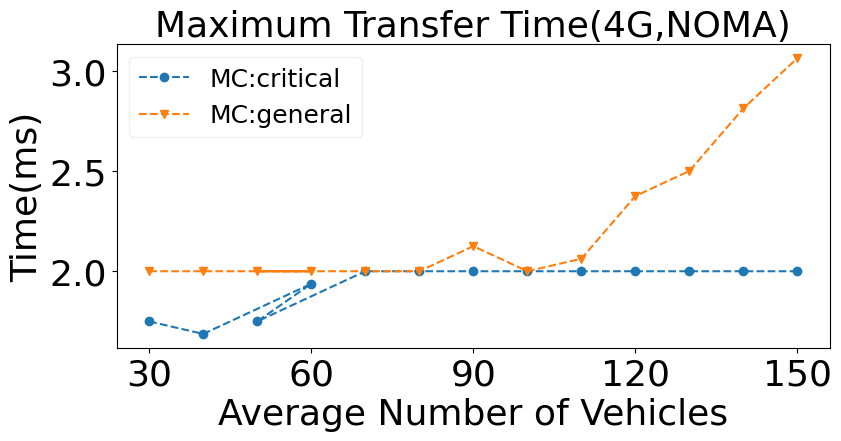

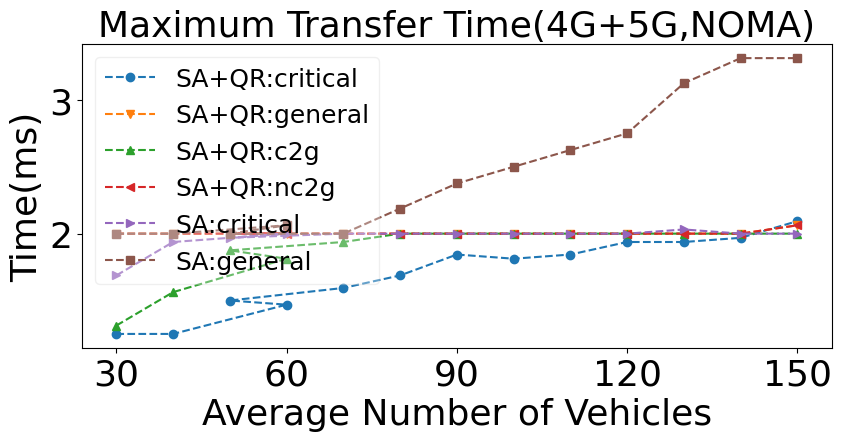

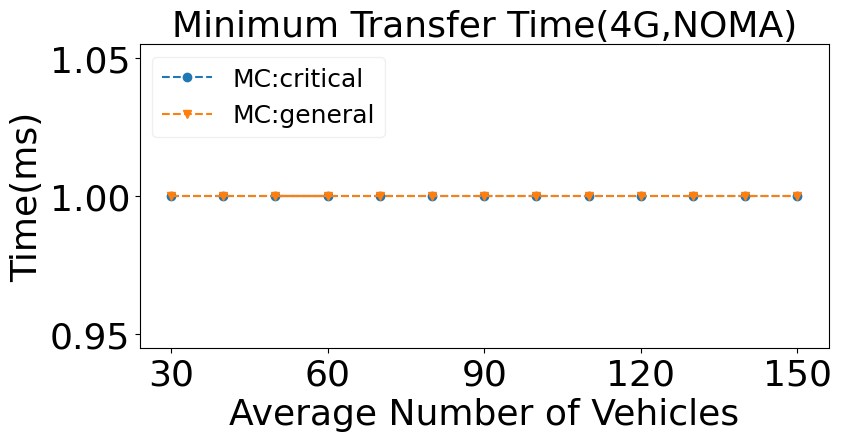

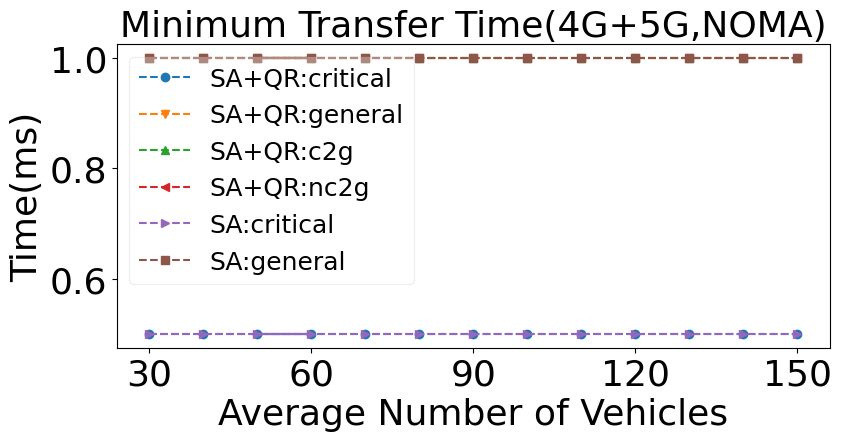

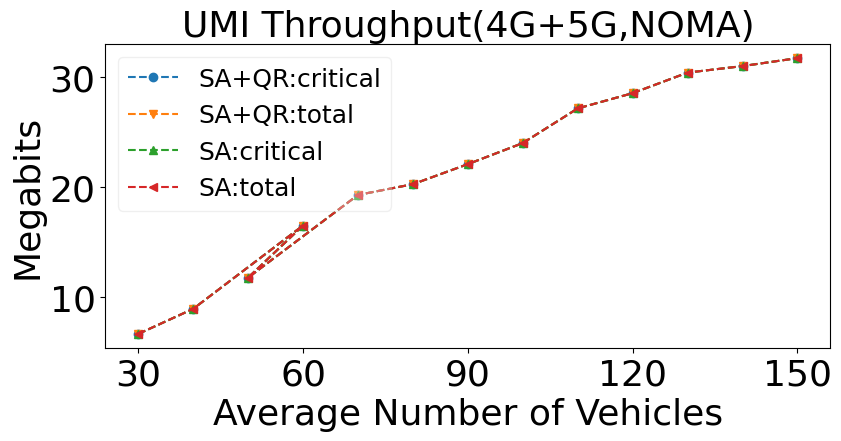

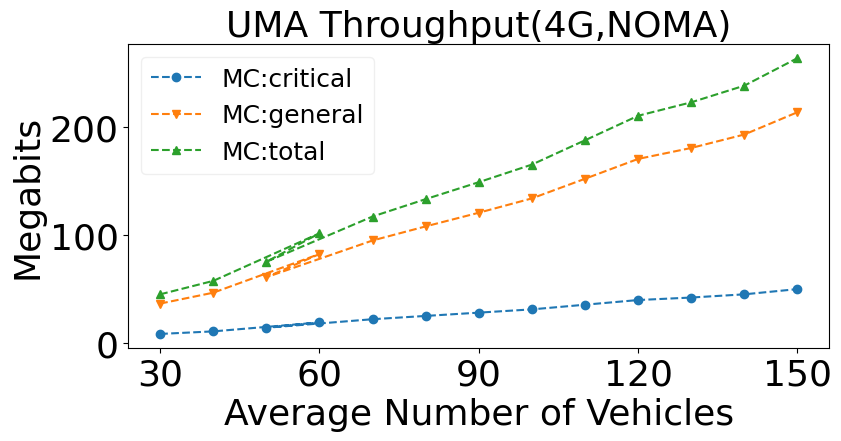

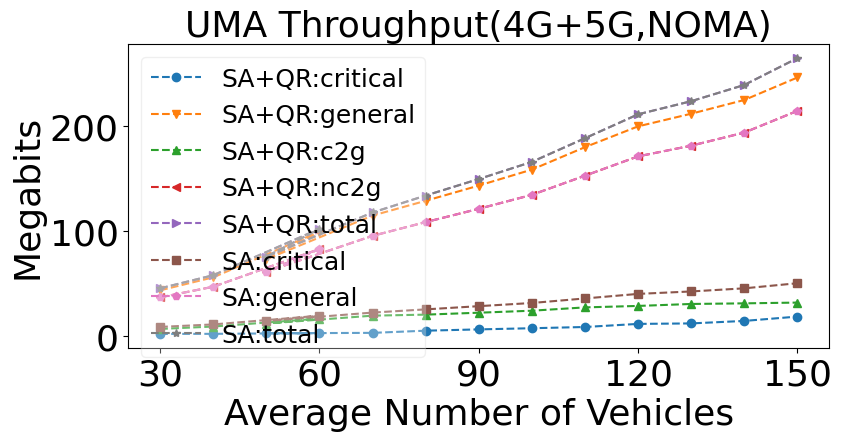

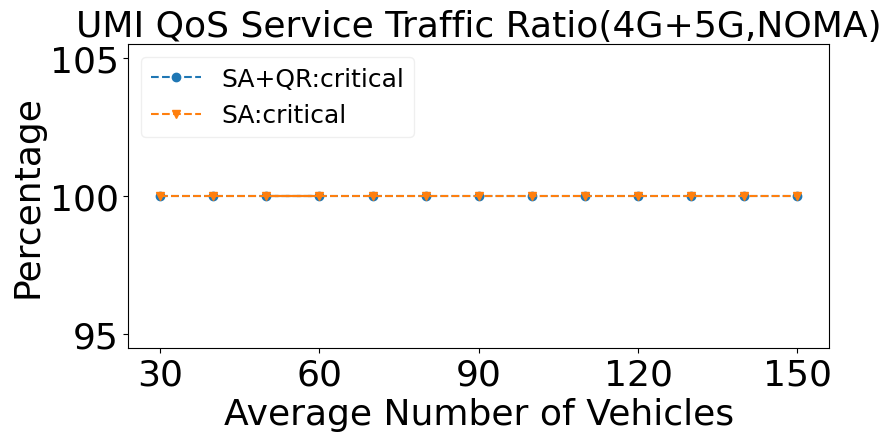

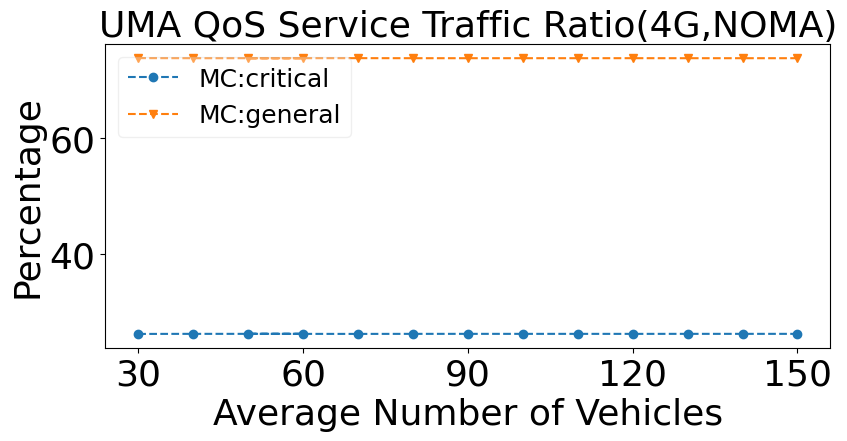

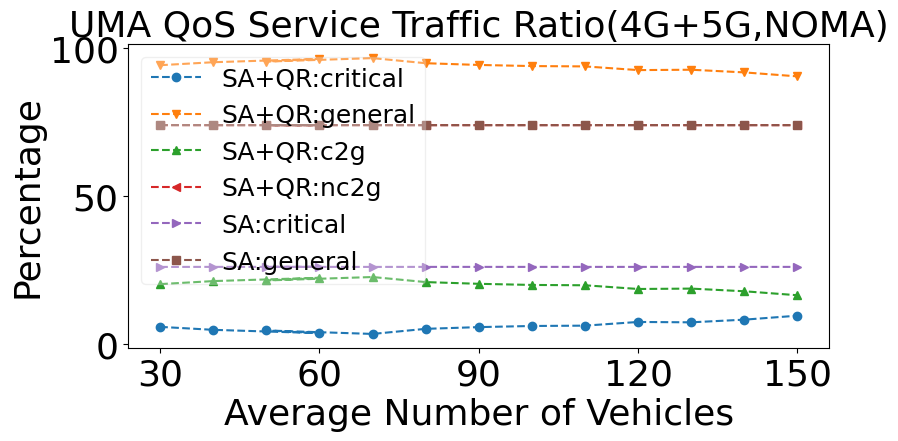

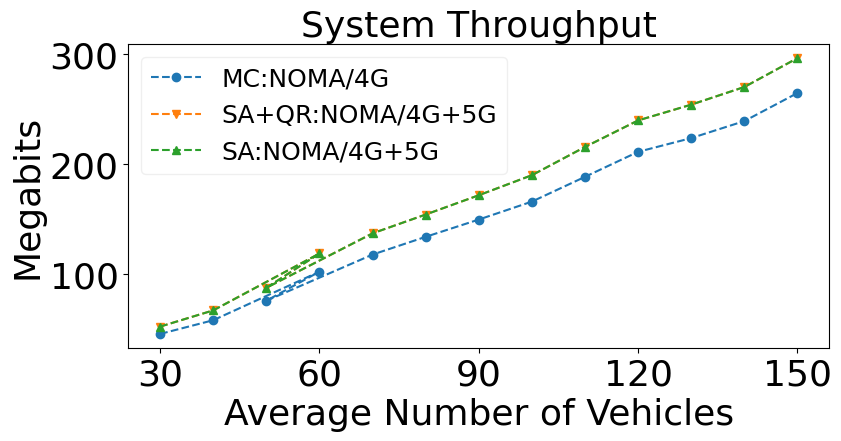

In [27]:
ShowGraphs(graphs,True)